# XGBoost on Donor Choose

![Imgur](https://imgur.com/GZSklhL.png)

# [DonorsChoose](https://en.wikipedia.org/wiki/DonorsChoose)

DonorsChoose is a United States-based nonprofit organization that allows individuals to donate directly to public school classroom projects. The organization has been given Charity Navigator's highest rating every year since 2005.[4] In January 2018, they announced that 1 million projects had been funded. In 80% of public schools in the United States, at least one project has been requested on DonorsChoose. Schools from wealthy areas are more likely to make technology requests, while schools from less affluent areas are more likely to request basic supplies.[6] It has been noted that repeat donors on DonorsChoose typically donate to projects they have no prior relationship with, and most often fund projects serving financially challenged students.

---

# About the DonorsChoose Data Set

The `train.csv` data set provided by DonorsChoose contains the following features:

Feature | Description 
----------|---------------
**`project_id`** | A unique identifier for the proposed project. **Example:** `p036502`   
**`project_title`**    | Title of the project. **Examples:**<br><ul><li><code>Art Will Make You Happy!</code></li><li><code>First Grade Fun</code></li></ul> 
**`project_grade_category`** | Grade level of students for which the project is targeted. One of the following enumerated values: <br/><ul><li><code>Grades PreK-2</code></li><li><code>Grades 3-5</code></li><li><code>Grades 6-8</code></li><li><code>Grades 9-12</code></li></ul>  
 **`project_subject_categories`** | One or more (comma-separated) subject categories for the project from the following enumerated list of values:  <br/><ul><li><code>Applied Learning</code></li><li><code>Care &amp; Hunger</code></li><li><code>Health &amp; Sports</code></li><li><code>History &amp; Civics</code></li><li><code>Literacy &amp; Language</code></li><li><code>Math &amp; Science</code></li><li><code>Music &amp; The Arts</code></li><li><code>Special Needs</code></li><li><code>Warmth</code></li></ul><br/> **Examples:** <br/><ul><li><code>Music &amp; The Arts</code></li><li><code>Literacy &amp; Language, Math &amp; Science</code></li>  
  **`school_state`** | State where school is located ([Two-letter U.S. postal code](https://en.wikipedia.org/wiki/List_of_U.S._state_abbreviations#Postal_codes)). **Example:** `WY`
**`project_subject_subcategories`** | One or more (comma-separated) subject subcategories for the project. **Examples:** <br/><ul><li><code>Literacy</code></li><li><code>Literature &amp; Writing, Social Sciences</code></li></ul> 
**`project_resource_summary`** | An explanation of the resources needed for the project. **Example:** <br/><ul><li><code>My students need hands on literacy materials to manage sensory needs!</code</li></ul> 
**`project_essay_1`**    | First application essay<sup>*</sup>  
**`project_essay_2`**    | Second application essay<sup>*</sup> 
**`project_essay_3`**    | Third application essay<sup>*</sup> 
**`project_essay_4`**    | Fourth application essay<sup>*</sup> 
**`project_submitted_datetime`** | Datetime when project application was submitted. **Example:** `2016-04-28 12:43:56.245`   
**`teacher_id`** | A unique identifier for the teacher of the proposed project. **Example:** `bdf8baa8fedef6bfeec7ae4ff1c15c56`  
**`teacher_prefix`** | Teacher's title. One of the following enumerated values: <br/><ul><li><code>nan</code></li><li><code>Dr.</code></li><li><code>Mr.</code></li><li><code>Mrs.</code></li><li><code>Ms.</code></li><li><code>Teacher.</code></li></ul>  
**`teacher_number_of_previously_posted_projects`** | Number of project applications previously submitted by the same teacher. **Example:** `2` 

<sup>*</sup> See the section <b>Notes on the Essay Data</b> for more details about these features.

Additionally, the `resources.csv` data set provides more data about the resources required for each project. Each line in this file represents a resource required by a project:

Feature | Description 
----------|---------------
**`id`** | A `project_id` value from the `train.csv` file.  **Example:** `p036502`   
**`description`** | Desciption of the resource. **Example:** `Tenor Saxophone Reeds, Box of 25`   
**`quantity`** | Quantity of the resource required. **Example:** `3`   
**`price`** | Price of the resource required. **Example:** `9.95`   

**Note:** Many projects require multiple resources. The `id` value corresponds to a `project_id` in train.csv, so you use it as a key to retrieve all resources needed for a project:

The data set contains the following label (the value you will attempt to predict):

Label | Description
----------|---------------
`project_is_approved` | A binary flag indicating whether DonorsChoose approved the project. A value of `0` indicates the project was not approved, and a value of `1` indicates the project was approved.

#### Response Coding: Example

In [ ]:
import os
for dirname, _, filenames in os.walk('../input/donorschooseorg-application-screening'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
import os
for dirname, _, filenames in os.walk('../input/preprocesseddonorchoose'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

## 1.1 Loading Data

In [58]:
# COLAB WITH GOOGLE DRIVE
# !pip install wordcloud
# from google.colab import drive
# drive.mount('/content/gdrive')
# root_path = '/content/gdrive/MyDrive/DonorChoose/preprocessed_data.csv'
# glove_vector_path = '/content/gdrive/MyDrive/DonorChoose/glove_vectors'

#KAGGLE
root_path = '../input/preprocesseddonorchoose/preprocessed_data.csv'
glove_vector_path = '../input/glove-vector'

# LOCAL MACHINE
# root_path = '../LARGE_Datasets/preprocessed_data.csv'
# glove_vector_path = '../LARGE_Datasets/glove_vectors'

import warnings 
warnings.filterwarnings("ignore") 

import pandas as pd
import numpy as np

from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.model_selection import GridSearchCV
from prettytable import PrettyTable
from sklearn.metrics import roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

from scipy.sparse import hstack
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns
sns.set()

import pickle
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from sklearn.svm import LinearSVC
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import expon

from collections import Counter
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score


# Save a Notebook session: (I could use .pkl as well to dump, but from .pkl could NOT load back a large dump size of 2.4GB)
# import dill
# dill.dump_session('notebook_env.db')

# Restore a Notebook session:
# import dill
# dill.load_session('notebook_env.db')

org_preprocessed = pd.read_csv(root_path, nrows=500)
org_preprocessed.head(2)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/paul/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,essay,price
0,ca,mrs,grades_prek_2,53,1,math_science,appliedsciences health_lifescience,i fortunate enough use fairy tale stem kits cl...,725.05
1,ut,ms,grades_3_5,4,1,specialneeds,specialneeds,imagine 8 9 years old you third grade classroo...,213.03


In [59]:
# Sentiment Analysis on 'essay'
sid    = SentimentIntensityAnalyzer()

negative_sentiments = []
positive_sentiments = []
neutral_sentiments = []
compound_sentiments = []

for i in tqdm(org_preprocessed['essay']):
  sid_sentiments = sid.polarity_scores(i)
  negative_sentiments.append(sid_sentiments['neg'])
  positive_sentiments.append(sid_sentiments['pos'])
  neutral_sentiments.append(sid_sentiments['neu'])
  compound_sentiments.append(sid_sentiments['compound'])
  
# Now append these sentiments columns/freatures to original preprocessed dataframe
org_preprocessed['negative_sent'] = negative_sentiments
org_preprocessed['positive_sent'] = positive_sentiments
org_preprocessed['neutral_sent'] = neutral_sentiments
org_preprocessed['compound_sent'] = compound_sentiments

org_preprocessed.head(1)


100%|██████████| 500/500 [00:00<00:00, 716.19it/s]


,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,essay,price,negative_sent,positive_sent,neutral_sent,compound_sent
0,ca,mrs,grades_prek_2,53,1,math_science,appliedsciences health_lifescience,i fortunate enough use fairy tale stem kits cl...,725.05,0.013,0.205,0.783,0.9867


In [60]:
Y = org_preprocessed['project_is_approved'].values
X = org_preprocessed.drop(['project_is_approved'], axis=1)
print(Y.shape)
print(X.shape)

(500,)
(500, 12)


<h2>1.2 Splitting data into Train and cross validation(or test): Stratified Sampling</h2>

In [61]:

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(350, 12) (350,)
(150, 12) (150,)


# Set 1 - : 

### - categorical (instead of one hot encoding, try <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/handling-categorical-and-numerical-features/'>response coding</a>: use probability values) + 
### - numerical features + 
### - project_title(TFIDF) +  
### - preprocessed_eassay (TFIDF)+ 
### - sentiment Score of eassay( include all 4 values as 4 features)

# 1.3 Make Data Model Ready: encoding eassay (BoW)



In [62]:
# As required for Task-1, applying TFIDF on the Essay column
vectorizer_essay_tfidf = TfidfVectorizer(min_df=10)

# Apply .fit() on this vectorizer on Train data
# Note .fit() is applied only on the train data, as test and cv should not be fitted
vectorizer_essay_tfidf.fit(X_train['essay'].values)

# Now use the fitted TfidfVectorizer for converting 'essay' text to Vector form
X_train_vectorized_tfidf_essay = vectorizer_essay_tfidf.transform(X_train['essay'].values)
X_test_vectorized_tfidf_essay = vectorizer_essay_tfidf.transform(X_test['essay'].values)

print('After TFIDF on Essay column checking the shapes ')
print(X_train_vectorized_tfidf_essay.shape, y_train.shape)
print(X_test_vectorized_tfidf_essay.shape, y_test.shape)

After TFIDF on Essay column checking the shapes 
(350, 817) (350,)
(150, 817) (150,)


# 1.4 Make Data Model Ready: encoding categorical features

## Categorial Featues are => school_state, teacher_prefix, project_grade_category, clean_categories, clean_subcategories, essay

## The function to implement response-encoding by first doint fit and then transform the categorical features on train and test data.

In [63]:

""" Function to response-encode categorical features - fit()

Basically generate three Counter dict for total of a feature and 
feature_when_class_is_0 and feature_when_class_is_1

args:
  x_train_feature_total => df of the form (from Training data) => x['feature_name'] 
  x_train_feature_0 => of form (from Training data) => x.loc[x['project_is_approved']== 0]['feature_name']
  x_train_feature_1 => of form (from Training data) => x.loc[x['project_is_approved']== 1]['feature_name']
  
  returns:
     dictionary (dict) => Of form => Counter({'ca': 53, 'in': 21,... }) for "school_state" feature
"""


def response_encoding_fit(x_train_feature_total, x_train_feature_0, x_train_feature_1):
  feature_counter_total = Counter()
  feature_counter_total.update(i for i in x_train_feature_total)
  # For 'school_state' feature, above will generate a counter dict like below
  # Includes both class 0 and 1 in this
  # ({'ca': 469, 'mi': 80, 'ny': 199, ... })
  # Noting The counter is a sub-class available inside the dictionary class. Using Counter tool, 
  # we can count the key-value pairs in an object, also called a hash table object.
  
  feature_counter_0 = Counter()  # Create a dict variable to act as a Counter
  feature_counter_0.update(i for i in x_train_feature_0)   # adding values to the Counter from x_train_feature_0
  # it will be of form => Counter({'fl': 2, 'nv': 1, 'ca': 9,...})
  
  # Now update feature_counter_0 with all the non-existing keys
  # i.e. keys that exist in feature_counter_total but NOT in feature_counter_0
  for i in feature_counter_total:         # i is each key (e.g. 'ca', 'fl' etc for school_state)
    if i not in feature_counter_0:        # If a key is not there in feature_counter_0
      feature_counter_0[i] = 0            # set the value of that key be 0 in dict feature_counter_0
    
  # Similary do the same for x_train_feature_1
  feature_counter_1 = Counter()
  feature_counter_1.update(i for i in x_train_feature_1)
    
  for i in feature_counter_total:
    if i not in feature_counter_1:
      feature_counter_1[i] = 0
      
  return feature_counter_total, feature_counter_0, feature_counter_1

""" Now Function to tranform (generate proba array) for response-encoded categorical features

args:
  x_feature_train => X_train['feature_name']
  feature_counter_0 and feature_counter_1 => These are Counter / dict variable returned from response_encoding_fit()  
  
  returns:
     List of Probabilities => Of form => 
     [[0.04761905]
      [0.16981132]
      [0.16981132]]
"""

def response_encoding_transform(x_feature_train, feature_counter_total, feature_counter_0, feature_counter_1):
  feature_proba_arr_0 = []
  feature_proba_arr_1 = []
  
  for i in x_feature_train:
    # Now loop over each feature-name e.g. 'ca', 'fl' etc for school_state
    if i in feature_counter_total.keys(): # if the specific unique feature-names exist in train data x_feature_train
      # .get(i) will give me the value of the key, i.e. the number count for each key (which represents the feature-name)
      proba_0 = feature_counter_0.get(i)/feature_counter_total.get(i) 
      proba_1 = feature_counter_1.get(i)/feature_counter_total.get(i)      
      
      feature_proba_arr_0.append(proba_0)
      feature_proba_arr_1.append(proba_1)
    else:
      feature_proba_arr_0.append(0.5)
      feature_proba_arr_1.append(0.5)      
  # Have to convert to array so I can invoke reshape() on these
  feature_proba_arr_0 = np.array(feature_proba_arr_0)
  feature_proba_arr_1 = np.array(feature_proba_arr_1)
    
  return feature_proba_arr_0.reshape(-1, 1), feature_proba_arr_1.reshape(-1, 1)

In [64]:
# Now make a new dataframe for all the categorical feature from only the train dataset
# And then I will response-encode these dataset.
# Categorial Featues are => school_state, teacher_prefix, project_grade_category, clean_categoris, clean_subcategories
df_cat_train_before_response_coding = pd.DataFrame(y_train, columns=['project_is_approved'])
df_cat_train_before_response_coding['school_state'] = X_train['school_state'].values
df_cat_train_before_response_coding['teacher_prefix'] = X_train['teacher_prefix'].values
df_cat_train_before_response_coding['project_grade_category'] = X_train['project_grade_category'].values
df_cat_train_before_response_coding['clean_categories'] = X_train['clean_categories'].values
df_cat_train_before_response_coding['clean_subcategories'] = X_train['clean_subcategories'].values
df_cat_train_before_response_coding.head(2)

,project_is_approved,school_state,teacher_prefix,project_grade_category,clean_categories,clean_subcategories
0,1,ma,mrs,grades_prek_2,math_science,appliedsciences
1,0,nj,ms,grades_prek_2,literacy_language,literacy literature_writing


## Response Encoding school_state

In [65]:
x_train_feature_total = df_cat_train_before_response_coding['school_state']
x_train_feature_0 = df_cat_train_before_response_coding.loc[df_cat_train_before_response_coding['project_is_approved']==0]['school_state']
x_train_feature_1 = df_cat_train_before_response_coding.loc[df_cat_train_before_response_coding['project_is_approved']==1]['school_state']

school_state_counter_total, school_state_counter_0, school_state_counter_1 = response_encoding_fit(x_train_feature_total, x_train_feature_0, x_train_feature_1 )

X_train_school_state_response_proba_0, X_train_school_state_response_proba_1 = response_encoding_transform(X_train['school_state'], school_state_counter_total, school_state_counter_0, school_state_counter_1)

X_test_school_state_response_proba_0, X_test_school_state_response_proba_1 = response_encoding_transform(X_test['school_state'], school_state_counter_total, school_state_counter_0, school_state_counter_1)

print(np.mean(X_train_school_state_response_proba_0, axis=0))
print(X_train_school_state_response_proba_0.shape, y_train.shape)
print(X_test_school_state_response_proba_0.shape, y_test.shape)


[0.12571429]
(350, 1) (350,)
(150, 1) (150,)


## Response Encoding teacher_prefix

In [66]:
x_train_feature_total = df_cat_train_before_response_coding['teacher_prefix']
x_train_feature_0 = df_cat_train_before_response_coding.loc[df_cat_train_before_response_coding['project_is_approved']==0]['teacher_prefix']
x_train_feature_1 = df_cat_train_before_response_coding.loc[df_cat_train_before_response_coding['project_is_approved']==1]['teacher_prefix']

teacher_prefix_counter_total, teacher_prefix_counter_0, teacher_prefix_counter_1 = response_encoding_fit(x_train_feature_total, x_train_feature_0, x_train_feature_1 )

X_train_teacher_prefix_response_proba_0, X_train_teacher_prefix_response_proba_1 = response_encoding_transform(X_train['teacher_prefix'], teacher_prefix_counter_total, teacher_prefix_counter_0, teacher_prefix_counter_1)

X_test_teacher_prefix_response_proba_0, X_test_teacher_prefix_response_proba_1 = response_encoding_transform(X_test['teacher_prefix'], teacher_prefix_counter_total, teacher_prefix_counter_0, teacher_prefix_counter_1)

print(np.mean(X_train_teacher_prefix_response_proba_0, axis=0))
print(X_train_teacher_prefix_response_proba_0.shape, y_train.shape)
print(X_test_teacher_prefix_response_proba_0.shape, y_test.shape)



[0.12571429]
(350, 1) (350,)
(150, 1) (150,)


## Response Encoding project_grade_category

In [67]:
x_train_feature_total = df_cat_train_before_response_coding['project_grade_category']
x_train_feature_0 = df_cat_train_before_response_coding.loc[df_cat_train_before_response_coding['project_is_approved']==0]['project_grade_category']
x_train_feature_1 = df_cat_train_before_response_coding.loc[df_cat_train_before_response_coding['project_is_approved']==1]['project_grade_category']

project_grade_category_counter_total, project_grade_category_counter_0, project_grade_category_counter_1 = response_encoding_fit(x_train_feature_total, x_train_feature_0, x_train_feature_1 )

X_train_project_grade_category_response_proba_0, X_train_project_grade_category_response_proba_1 = response_encoding_transform(X_train['project_grade_category'], project_grade_category_counter_total, project_grade_category_counter_0, project_grade_category_counter_1)

X_test_project_grade_category_response_proba_0, X_test_project_grade_category_response_proba_1 = response_encoding_transform(X_test['project_grade_category'], project_grade_category_counter_total, project_grade_category_counter_0, project_grade_category_counter_1)

print(np.mean(X_train_project_grade_category_response_proba_0, axis=0))
print(X_train_project_grade_category_response_proba_0.shape, y_train.shape)
print(X_test_project_grade_category_response_proba_0.shape, y_test.shape)

[0.12571429]
(350, 1) (350,)
(150, 1) (150,)


## Response Encoding clean_categories

In [68]:
x_train_feature_total = df_cat_train_before_response_coding['clean_categories']
x_train_feature_0 = df_cat_train_before_response_coding.loc[df_cat_train_before_response_coding['project_is_approved']==0]['clean_categories']
x_train_feature_1 = df_cat_train_before_response_coding.loc[df_cat_train_before_response_coding['project_is_approved']==1]['clean_categories']

clean_categories_counter_total, clean_categories_counter_0, clean_categories_counter_1 = response_encoding_fit(x_train_feature_total, x_train_feature_0, x_train_feature_1 )

X_train_clean_categories_response_proba_0, X_train_clean_categories_response_proba_1 = response_encoding_transform(X_train['clean_categories'], clean_categories_counter_total, clean_categories_counter_0, clean_categories_counter_1)

X_test_clean_categories_response_proba_0, X_test_clean_categories_response_proba_1 = response_encoding_transform(X_test['clean_categories'], clean_categories_counter_total, clean_categories_counter_0, clean_categories_counter_1)

print(np.mean(X_train_clean_categories_response_proba_0, axis=0))
print(X_train_clean_categories_response_proba_0.shape, y_train.shape)
print(X_test_clean_categories_response_proba_0.shape, y_test.shape)

[0.12571429]
(350, 1) (350,)
(150, 1) (150,)


## Response Encoding - clean_subcategories

In [69]:
x_train_feature_total = df_cat_train_before_response_coding['clean_subcategories']
x_train_feature_0 = df_cat_train_before_response_coding.loc[df_cat_train_before_response_coding['project_is_approved']==0]['clean_subcategories']
x_train_feature_1 = df_cat_train_before_response_coding.loc[df_cat_train_before_response_coding['project_is_approved']==1]['clean_subcategories']

clean_subcategories_counter_total, clean_subcategories_counter_0, clean_subcategories_counter_1 = response_encoding_fit(x_train_feature_total, x_train_feature_0, x_train_feature_1 )

X_train_clean_subcategories_response_proba_0, X_train_clean_subcategories_response_proba_1 = response_encoding_transform(X_train['clean_subcategories'], clean_subcategories_counter_total, clean_subcategories_counter_0, clean_subcategories_counter_1)

X_test_clean_subcategories_response_proba_0, X_test_clean_subcategories_response_proba_1 = response_encoding_transform(X_test['clean_subcategories'], clean_subcategories_counter_total, clean_subcategories_counter_0, clean_subcategories_counter_1)

print(np.mean(X_train_clean_subcategories_response_proba_0, axis=0))
print(X_train_clean_subcategories_response_proba_0.shape, y_train.shape)
print(X_test_clean_subcategories_response_proba_0.shape, y_test.shape)

[0.12571429]
(350, 1) (350,)
(150, 1) (150,)


# 1.4 Make Data Model Ready: encoding numerical features

## Encoding numerical column - Price

In [70]:
normalizer = Normalizer()

normalizer.fit(X_train['price'].values.reshape(-1, 1))

X_train_normalized_price = normalizer.transform(X_train['price'].values.reshape(-1,1))
X_test_normalized_price = normalizer.transform(X_test['price'].values.reshape(-1,1))

print('After Normalizing on price column checking the shapes ')
# print('X_train_normalized_price ', X_train_normalized_price)
print(X_train_normalized_price.shape, y_train.shape)
print(X_test_normalized_price.shape, y_test.shape)

After Normalizing on price column checking the shapes 
(350, 1) (350,)
(150, 1) (150,)


## Encoding numerical column - teacher_number_of_previously_posted_projects

In [71]:
normalizer = Normalizer()

normalizer.fit(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1))

X_train_normalized_teacher_number_of_previously_posted_projects = normalizer.transform(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
X_test_normalized_teacher_number_of_previously_posted_projects = normalizer.transform(X_test['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))

print('After Normalizing on teacher_number_of_previously_posted_projects column checking the shapes ')
# print('X_train_normalized_teacher_number_of_previously_posted_projects ', X_train_normalized_teacher_number_of_previously_posted_projects)
print(X_train_normalized_teacher_number_of_previously_posted_projects.shape, y_train.shape)
print(X_test_normalized_teacher_number_of_previously_posted_projects.shape, y_test.shape)

After Normalizing on teacher_number_of_previously_posted_projects column checking the shapes 
(350, 1) (350,)
(150, 1) (150,)


## Standardize and then .fit() and .transform() all the Sentiments related Columns

In [72]:
sentiments_standardizer = StandardScaler()

# First applying the .fit() on the train data to find Mean and SD
sentiments_standardizer.fit(X_train['negative_sent'].values.reshape(-1,1))

# Now applying .transform() to train, test and cv data
X_train_negative_sent_standardized = sentiments_standardizer.transform(X_train['negative_sent'].values.reshape(-1,1))
X_test_negative_sent_standardized = sentiments_standardizer.transform(X_test['negative_sent'].values.reshape(-1,1))

print('After Standardizing on negative_sent column checking the shapes ')
print(X_train_negative_sent_standardized.shape, y_train.shape)
print(X_test_negative_sent_standardized.shape, y_test.shape)

After Standardizing on negative_sent column checking the shapes 
(350, 1) (350,)
(150, 1) (150,)


In [73]:
# First applying the .fit() on the train data to find Mean and SD
sentiments_standardizer.fit(X_train['positive_sent'].values.reshape(-1,1))

# Now applying .transform() to train, test and cv data
X_train_positive_sent_standardized = sentiments_standardizer.transform(X_train['positive_sent'].values.reshape(-1,1))
X_test_positive_sent_standardized = sentiments_standardizer.transform(X_test['positive_sent'].values.reshape(-1,1))

print('After Standardizing on positive_sent column checking the shapes ')
print(X_train_positive_sent_standardized.shape, y_train.shape)
print(X_test_positive_sent_standardized.shape, y_test.shape)

After Standardizing on positive_sent column checking the shapes 
(350, 1) (350,)
(150, 1) (150,)


In [74]:
# First applying the .fit() on the train data to find Mean and SD
sentiments_standardizer.fit(X_train['neutral_sent'].values.reshape(-1,1))

# Now applying .transform() to train, test and cv data
X_train_neutral_sent_standardized = sentiments_standardizer.transform(X_train['neutral_sent'].values.reshape(-1,1))
X_test_neutral_sent_standardized = sentiments_standardizer.transform(X_test['neutral_sent'].values.reshape(-1,1))

print('After Standardizing on neutral_sent column checking the shapes ')
# print('X_train_neutral_sent_standardized ', X_train_neutral_sent_standardized)
print(X_train_neutral_sent_standardized.shape, y_train.shape)
print(X_test_neutral_sent_standardized.shape, y_test.shape)

After Standardizing on neutral_sent column checking the shapes 
(350, 1) (350,)
(150, 1) (150,)


In [75]:
# First applying the .fit() on the train data to find Mean and SD
sentiments_standardizer.fit(X_train['compound_sent'].values.reshape(-1,1))

# Now applying .transform() to train, test and cv data
X_train_compound_sent_standardized = sentiments_standardizer.transform(X_train['compound_sent'].values.reshape(-1,1))
X_test_compound_sent_standardized = sentiments_standardizer.transform(X_test['compound_sent'].values.reshape(-1,1))

print('After Standardizing on compound_sent column checking the shapes ')
# print('X_train_compound_sent_standardized ', X_train_compound_sent_standardized)
print(X_train_compound_sent_standardized.shape, y_train.shape)
print(X_test_compound_sent_standardized.shape, y_test.shape)

After Standardizing on compound_sent column checking the shapes 
(350, 1) (350,)
(150, 1) (150,)


# Set S1 - Merging (with hstack) all the above vectorized features that we created above

`hstack((X1, X2))`

### We need to merge all the numerical vectors i.e catogorical, text, once for Set S1 and then for S2 later

In [76]:
X_train_s1_merged = hstack((X_train_vectorized_tfidf_essay, X_train_school_state_response_proba_0, X_train_teacher_prefix_response_proba_0 , X_train_project_grade_category_response_proba_0 , X_train_clean_categories_response_proba_0 , X_train_clean_subcategories_response_proba_0, X_train_normalized_price, X_train_normalized_teacher_number_of_previously_posted_projects, X_train_negative_sent_standardized, X_train_positive_sent_standardized , X_train_neutral_sent_standardized, X_train_compound_sent_standardized )).tocsr()



X_test_s1_merged = hstack((X_test_vectorized_tfidf_essay, X_test_school_state_response_proba_0, X_test_teacher_prefix_response_proba_0 , X_test_project_grade_category_response_proba_0 , X_test_clean_categories_response_proba_0 , X_test_clean_subcategories_response_proba_0, X_test_normalized_price, X_test_normalized_teacher_number_of_previously_posted_projects, X_test_negative_sent_standardized, X_test_positive_sent_standardized , X_test_neutral_sent_standardized, X_test_compound_sent_standardized )).tocsr()


print("X_train_s1_merged.shape & y_train.shape ", X_train_s1_merged.shape, y_train.shape)
print("X_test_s1_merged.shape & y_train.shape ", X_test_s1_merged.shape, y_test.shape)

X_train_s1_merged.shape & y_train.shape  (350, 828) (350,)
X_test_s1_merged.shape & y_train.shape  (150, 828) (150,)


# Set S1 - GridSearchCV with XGBClassifier


In [77]:
# xgb_clf_s1 = XGBClassifier(booster='gblinear', reg_alpha=0, reg_lambda=0, eval_metric='mlogloss')
# xgb_clf_s1 = XGBClassifier(booster='gblinear', reg_alpha=0, reg_lambda=0, tree_method='gpu_hist', eval_metric='mlogloss')
xgb_clf_s1 = XGBClassifier(eval_metric='mlogloss')

params = {
'eta': [0.0001, 0.001, 0.01, 0.1, 0.2],
'n_estimators': [30, 40, 50, 60],
'tree_method':['gpu_hist']
}

# params = {
# 'eta': [0.0001, 0.001, 0.01, 0.1, 0.2],
# 'n_estimators': [30, 40, 50, 60]
# }

grid_search_s1 = GridSearchCV(xgb_clf_s1, params, cv=3, scoring='roc_auc', return_train_score=True)

grid_search_s1.fit(X_train_s1_merged, y_train)

best_params_gridsearch_xgb_s1 = grid_search_s1.best_params_

print("Best Params from GridSearchCV with XGB for Set s1 ", best_params_gridsearch_xgb_s1)


<h2>1.5 Appling Models on different kind of featurization as mentioned in the instructions</h2>

<br>Apply GBDT on different kind of featurization as mentioned in the instructions
<br> For Every model that you work on make sure you do the step 2 and step 3 of instrucations

## AUC for Set S1

In [ ]:
learning_rates = [0.0001, 0.001, 0.01, 0.1, 1]
n_estimators = [30, 40, 50, 60]
    
def get_auc_matrix(x_train, x_test, y_train, y_test ):    

    train_auc_final_arr, test_auc_final_arr = [], []

    for l_rate in tqdm(learning_rates):
        train_auc_batch, test_auc_batch = [], []
        
        for num in n_estimators:
            xgb_clf = XGBClassifier(n_estimators=num, learning_rate=l_rate, reg_alpha=0, reg_lambda=0, booster='gblinear', tree_method='gpu_hist')
            xgb_clf.fit(x_train, y_train)

            # I have to predict probabilities (clf.predict_proba) instead of classes for calculating of ROC AUC score:
            y_train_predicted = xgb_clf.predict_proba(x_train)[:, 1]
            y_test_predicted = xgb_clf.predict_proba(x_test)[:, 1]

            train_auc = roc_auc_score(y_train, y_train_predicted)
            test_auc = roc_auc_score(y_test, y_test_predicted)

            train_auc_batch.append(train_auc)
            test_auc_batch.append(test_auc)
        
        train_auc_final_arr.append(train_auc_batch)
        test_auc_final_arr.append(test_auc_batch)

    return train_auc_final_arr, test_auc_final_arr


train_auc_final_arr_s1, test_auc_final_arr_s1 = get_auc_matrix(X_train_s1_merged, X_test_s1_merged, y_train, y_test)

print(train_auc_final_arr_s1)
print(test_auc_final_arr_s1)


Error: Session cannot generate requests

## Heatmap for Set S1

<AxesSubplot:>

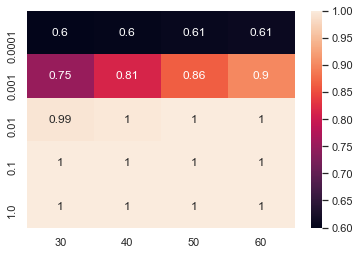

In [ ]:
train_auc_final_df_s1 = pd.DataFrame(train_auc_final_arr_s1, columns=n_estimators, index=learning_rates)
sns.heatmap(train_auc_final_df_s1, annot=True)
# train_auc_final_df_s1

<AxesSubplot:>

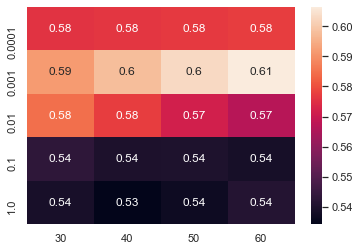

In [ ]:
test_auc_final_df_s1 = pd.DataFrame(test_auc_final_arr_s1, columns=n_estimators, index=learning_rates)
sns.heatmap(test_auc_final_df_s1, annot=True)
# test_auc_final_df_s1

## ROC Curve for Set S1

#### Note we earlier calculate the Best Params from GridSearchCV with XGB for Set s1 as {'eta': 0.01, 'n_estimators': 30}


[00:29:59] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


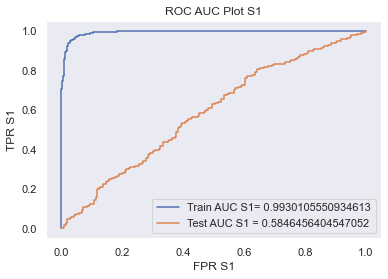

In [ ]:
xgb_clf = XGBClassifier(n_estimators=30, learning_rate=0.01, reg_alpha=0, reg_lambda=0, booster='gblinear', tree_method='gpu_hist')

xgb_clf.fit(X_train_s1_merged, y_train)

# I have to predict probabilities (clf.predict_proba) instead of classes for calculating of ROC AUC score:
y_train_predicted = xgb_clf.predict_proba(X_train_s1_merged)[:, 1]
y_test_predicted = xgb_clf.predict_proba(X_test_s1_merged)[:, 1]

train_fpr_s1, train_tpr_s1, train_thresholds_s1 = roc_curve(y_train, y_train_predicted)

test_fpr_s1, test_tpr_s1, test_thresholds_s1 = roc_curve(y_test, y_test_predicted)

plt.plot(train_fpr_s1, train_tpr_s1, label="Train AUC S1= "+str(auc(train_fpr_s1, train_tpr_s1)))
plt.plot(test_fpr_s1, test_tpr_s1, label="Test AUC S1 = "+str(auc(test_fpr_s1, test_tpr_s1)))
plt.legend()
plt.xlabel("FPR S1")
plt.ylabel('TPR S1')
plt.title('ROC AUC Plot S1')
plt.grid()
plt.show()




## Confusion Matrix for Set S1

confusion_matrix_s1_train  [[ 436   23]
 [  83 2958]]


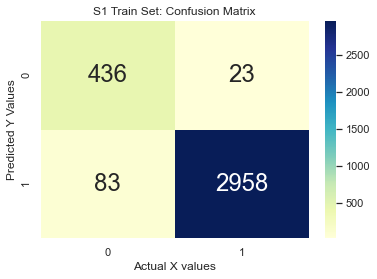

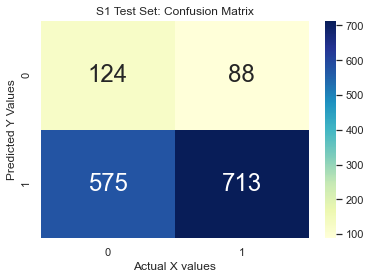

In [ ]:
# First the Function to get the Predicted Y_vector based on a given threshold and fpr & tpr
# This will be needed for Calculating Confusion Matrix

def get_predicted_y_vec_from_threshold(proba, threshold, fpr, tpr):
  
    # Using argmax to return the position of the largest value.
    # based on the calculated value of tpr*(1-fpr)
    # tpr * (1-fpr) i.e. optimal_threshold is maximum when fpr is very low and tpr is very high
    optimal_threshold = threshold[np.argmax(tpr * (1-fpr))]  
  
    predicted_y_vector = []
    for i in proba:
        if i >= optimal_threshold:
            predicted_y_vector.append(1)
        else:
            predicted_y_vector.append(0)

    return predicted_y_vector

confusion_matrix_s1_train = confusion_matrix(y_train, get_predicted_y_vec_from_threshold(y_train_predicted, train_thresholds_s1, train_fpr_s1, train_tpr_s1 ) )

confusion_matrix_s1_test = confusion_matrix(y_test, get_predicted_y_vec_from_threshold(y_test_predicted, test_thresholds_s1, test_fpr_s1, test_tpr_s1 ) )

print('confusion_matrix_s1_train ', confusion_matrix_s1_train)
# Heatmap for Confusion Matrix: Train and SET 1
heatmap_confusion_matrix_train_s1 = sns.heatmap(confusion_matrix_s1_train, annot=True, fmt='d', cmap="YlGnBu", annot_kws={"size": 24})

plt.title('S1 Train Set: Confusion Matrix')
plt.xlabel('Actual X values')
plt.ylabel('Predicted Y Values')
plt.show()

heatmap_confusion_matrix_test_s1 = sns.heatmap(confusion_matrix_s1_test, annot=True, fmt='d', cmap="YlGnBu", annot_kws={"size": 24})

plt.title('S1 Test Set: Confusion Matrix')
plt.xlabel('Actual X values')
plt.ylabel('Predicted Y Values')
plt.show()

# Set-2: categorical (response encoded), numerical features +  essay (TFIDF W2V) + Sentiment scores(preprocessed_essay)

The only change in Set-2 is the "essay" column - Now here I have to calculate the TFIDF W2V instead of just TFIDF

The rest of the Vectorized column will remain same as S1, and hence I just need adjust the merging step with hstack() - by using TFIDF W2V column for 'text' instead of just TFIDF

In [ ]:
with open(glove_vector_path, 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())
    
# In the TF-IDF Word2Vec vectorization, we have to fit the TfidfVectorizer only on X_train['essay'] and 
# extract 'dictionary' (dictionary with features as the keys and IDF scores as the values) and 
# 'tfidf_words' (a set of all the features extracted from the vectorizer). 
# We have to use the same 'dictionary' and 'tfidf_words' in vectorizing both X_train['essay'] and X_test['essay'].

# Now, at the very top section of this Notebook, we alrady have this code of Vectorizer on X_train data
# vectorizer_essay_tfidf = TfidfVectorizer(min_df=10)
# vectorizer_essay_tfidf.fit(X_train['essay'].values)

# Hence we are now converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(vectorizer_essay_tfidf.get_feature_names(), list(vectorizer_essay_tfidf.idf_)))
tfidf_words = set(vectorizer_essay_tfidf.get_feature_names())     

    
# Function to generate Word2Vec referencing "4_Reference_Vectorization.ipynb" given in the instruction
def generate_w2v_from_text(essays_text_arr):
  # compute average word2vec for each review.
    tfidf_w2v_vectors = []
    # the avg-w2v for each sentence/review is stored in this list

    for sentence in tqdm(essays_text_arr):  # for each sentence
        vector = np.zeros(300)  # as word vectors are of zero length
        tf_idf_weight = 0
        # num of words with a valid vector in the sentence
        for word in sentence.split():  # for each word in a sentence
            if (word in glove_words) and (word in tfidf_words):
                vec = model[word]  # getting the vector for each word
                # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
                tf_idf = dictionary[word] * (
                    sentence.count(word) / len(sentence.split())
                )  # getting the tfidf value for each word
                vector += vec * tf_idf  # calculating tfidf weighted w2v
                tf_idf_weight += tf_idf
        if tf_idf_weight != 0:
            vector /= tf_idf_weight
        tfidf_w2v_vectors.append(vector)
    return tfidf_w2v_vectors
  
X_train_vectorized_tfidf_w2v_essay = generate_w2v_from_text(X_train['essay'].values)
X_test_vectorized_tfidf_w2v_essay = generate_w2v_from_text(X_test['essay'].values)


100%|██████████| 1500/1500 [00:02<00:00, 586.33it/s]


In [ ]:
# from scipy import sparse

X_train_s2_merged = np.hstack(( X_train_vectorized_tfidf_w2v_essay, X_train_school_state_response_proba_0, X_train_teacher_prefix_response_proba_0 , X_train_project_grade_category_response_proba_0 , X_train_clean_categories_response_proba_0 , X_train_clean_subcategories_response_proba_0, X_train_normalized_price, X_train_normalized_teacher_number_of_previously_posted_projects, X_train_negative_sent_standardized, X_train_positive_sent_standardized , X_train_neutral_sent_standardized, X_train_compound_sent_standardized ))

# A = sparse.csr_matrix(X_train_s2_merged)
# print(A.shape)


X_test_s2_merged = np.hstack((X_test_vectorized_tfidf_w2v_essay, X_test_school_state_response_proba_0, X_test_teacher_prefix_response_proba_0 , X_test_project_grade_category_response_proba_0 , X_test_clean_categories_response_proba_0 , X_test_clean_subcategories_response_proba_0, X_test_normalized_price, X_test_normalized_teacher_number_of_previously_posted_projects, X_test_negative_sent_standardized, X_test_positive_sent_standardized , X_test_neutral_sent_standardized, X_test_compound_sent_standardized ))


print("X_train_s2_merged.shape & y_train.shape ", X_train_s2_merged.shape, y_train.shape)
print("X_test_s2_merged.shape & y_train.shape ", X_test_s2_merged.shape, y_test.shape)

X_train_s2_merged.shape & y_train.shape  (3500, 311) (3500,)
X_test_s2_merged.shape & y_train.shape  (1500, 311) (1500,)


# GridSearch on Set S2

In [ ]:
# xgb_clf_s2 = XGBClassifier(booster='gblinear', reg_alpha=0, reg_lambda=0)

xgb_clf_s2 = XGBClassifier(eval_metric='mlogloss')

params = {
'eta': [0.0001, 0.001, 0.01, 0.1, 0.2],
'n_estimators': [30, 40, 50, 60],
'tree_method':['gpu_hist']
}

grid_search_s2 = GridSearchCV(xgb_clf_s2, params, cv=3, scoring='roc_auc', return_train_score=True)

grid_search_s2.fit(X_train_s2_merged, y_train)

best_params_gridsearch_xgb_s2 = grid_search_s2.best_params_

print("Best Params from GridSearchCV with XGB for Set s2 ", best_params_gridsearch_xgb_s2)

[00:30:08] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:30:08] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:30:09] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:30:09] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

## AUC for Set S2

In [ ]:
train_auc_final_arr_s2, test_auc_final_arr_s2 = get_auc_matrix(X_train_s2_merged, X_test_s2_merged, y_train, y_test)
print("train_auc_final_arr_s2 ", train_auc_final_arr_s2)
print('test_auc_final_arr_s2 ', test_auc_final_arr_s2)

  0%|          | 0/5 [00:00<?, ?it/s]

[00:30:15] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:30:16] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:30:17] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:30:17] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

 20%|██        | 1/5 [00:01<00:05,  1.40s/it]

[00:30:17] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:30:17] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:30:17] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:30:18] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

 40%|████      | 2/5 [00:03<00:05,  1.68s/it]

[00:30:19] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:30:19] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:30:20] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:30:21] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

 60%|██████    | 3/5 [00:05<00:03,  1.75s/it]

[00:30:21] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:30:21] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:30:21] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 80%|████████  | 4/5 [00:06<00:01,  1.36s/it]

[00:30:21] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:30:22] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:30:22] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:30:22] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

100%|██████████| 5/5 [00:06<00:00,  1.28s/it]

train_auc_final_arr_s2  [[0.47907465079641415, 0.47959405911511455, 0.4801711396678222, 0.4807392649046903], [0.5041756846697172, 0.5182674114623744, 0.5326460665745344, 0.5472385746289454], [0.6789433300449412, 0.6963657179046854, 0.7090783260580347, 0.719597956468568], [0.7919902222279537, 0.8018783237654739, 0.8080309839599548, 0.8125587916484873], [0.5, 0.49634981326375416, 0.5, 0.5]]
test_auc_final_arr_s2  [[0.5130962146958865, 0.5134972313371616, 0.5138488075706082, 0.514198552677839], [0.5277287442868862, 0.5355934313840385, 0.5432109164420484, 0.5500959510137114], [0.5929992382514941, 0.5958118481190671, 0.5979908883159499, 0.5988844779092933], [0.5893809328489394, 0.5834737196765498, 0.5796796261572718, 0.577418185280675], [0.5, 0.49452127036212346, 0.5, 0.5]]


## Heatmap for Set S2

<AxesSubplot:>

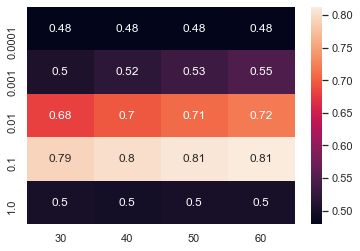

In [ ]:
train_auc_final_df_s2 = pd.DataFrame(train_auc_final_arr_s2, columns=n_estimators, index=learning_rates)
sns.heatmap(train_auc_final_df_s2, annot=True)
# train_auc_final_df_s2

<AxesSubplot:>

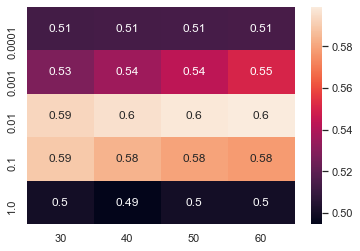

In [ ]:
test_auc_final_df_s2 = pd.DataFrame(test_auc_final_arr_s2, columns=n_estimators, index=learning_rates)
sns.heatmap(test_auc_final_df_s2, annot=True)
# test_auc_final_df_s2

## ROC Curve for Set S2


### Note we earlier calculate the Best Params from GridSearchCV with XGB for Set S2 as {'eta': 0.2, 'n_estimators': 60}

[00:30:22] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


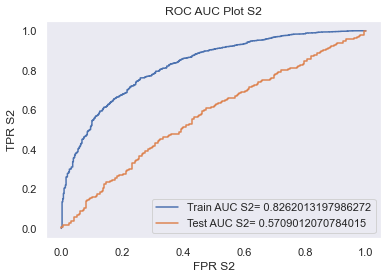

In [ ]:
xgb_clf = XGBClassifier(n_estimators=60, learning_rate=0.2, booster='gblinear', tree_method='gpu_hist')

xgb_clf.fit(X_train_s2_merged, y_train)

# I have to predict probabilities (clf.predict_proba) instead of classes for calculating of ROC AUC score:
y_train_predicted = xgb_clf.predict_proba(X_train_s2_merged)[:, 1]
y_test_predicted = xgb_clf.predict_proba(X_test_s2_merged)[:, 1]

train_fpr_s2, train_tpr_s2, train_thresholds_s2 = roc_curve(y_train, y_train_predicted)

test_fpr_s2, test_tpr_s2, test_thresholds_s2 = roc_curve(y_test, y_test_predicted)

plt.plot(train_fpr_s2, train_tpr_s2, label="Train AUC S2= "+str(auc(train_fpr_s2, train_tpr_s2)))
plt.plot(test_fpr_s2, test_tpr_s2, label="Test AUC S2= "+str(auc(test_fpr_s2, test_tpr_s2)))
plt.legend()
plt.xlabel("FPR S2")
plt.ylabel('TPR S2')
plt.title('ROC AUC Plot S2')
plt.grid()
plt.show()

## Confusion Matrix for Set S2

In [ ]:
# print(y_train)
# print(get_predicted_y_vec_from_threshold(y_train_predicted, train_thresholds_s2, train_fpr_s2, train_tpr_s2 ))

confusion_matrix_s2_train = confusion_matrix(y_train, get_predicted_y_vec_from_threshold
(y_train_predicted, train_thresholds_s2, train_fpr_s2, train_tpr_s2 ) )

confusion_matrix_s2_test = confusion_matrix(y_test, get_predicted_y_vec_from_threshold(y_test_predicted, test_thresholds_s2, test_fpr_s2, test_tpr_s2 ) )

print('confusion_matrix_s2_train ', confusion_matrix_s2_train)
# Heatmap for Confusion Matrix: Train and SET 1
heatmap_confusion_matrix_train_s2 = sns.heatmap(confusion_matrix_s2_train, annot=True, fmt='d', cmap="YlGnBu", annot_kws={"size": 24})

plt.title('s2 Train Set: Confusion Matrix')
plt.xlabel('Actual X values')
plt.ylabel('Predicted Y Values')
plt.show()

heatmap_confusion_matrix_test_s2 = sns.heatmap(confusion_matrix_s2_test, annot=True, fmt='d', cmap="YlGnBu", annot_kws={"size": 24})

plt.title('s2 Test Set: Confusion Matrix')
plt.xlabel('Actual X values')
plt.ylabel('Predicted Y Values')
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'notebook_env.pkl'

<h1>3. Summary</h1>

<br> as mentioned in the step 4 of instructions

In [ ]:
import pandas as pd

pd.DataFrame({
  'Model':['TfIdf',  'Tfidf-W2V'],
  'Train AUC': [0.87, 0.72],
  'Test AUC': [0.70, 0.69],

})

,Model,Train AUC,Test AUC
0,TfIdf,0.87,0.70
1,Tfidf-W2V,0.72,0.69


In [ ]:

# import dill
# dill.dump_session('notebook_env.pkl')

[[2 0 0]
 [0 0 1]
 [1 0 2]]
-------------------------------------------------- Confusion matrix --------------------------------------------------


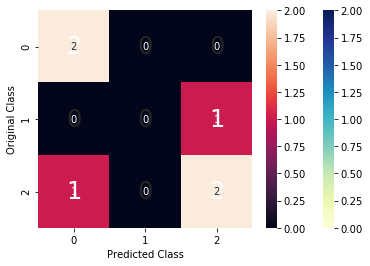

In [ ]:
plt.close()
test_y = [2, 0, 2, 2, 0, 1]
predict_y = [0, 0, 2, 2, 0, 2]

C = confusion_matrix(test_y, predict_y)

print(C)

labels = [1,2,3,4,5,6,7,8,9]
cmap=sns.light_palette("green")
# representing A in heatmap format
print("-"*50, "Confusion matrix", "-"*50)
# plt.figure(figsize=(10,5))
# sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
sns.heatmap(C, annot=True, fmt='d', cmap="YlGnBu", annot_kws={"size": 24})
sns.heatmap(C, annot=True)
plt.xlabel('Predicted Class')
plt.ylabel('Original Class')
plt.show()